# Setup

In [1]:
from itertools import chain

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import shapely.geometry
mpl.rcParams['figure.dpi'] = 100
import seaborn as sns
sns.set()

import shapely
import momepy
import networkx as nx

from src.space.utils import segmented
from src.space.road_network import RoadNetwork

/Users/boyu/GitHubProjects/agents-and-networks-in-python/venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# UB Walkway

In [2]:
ub_walkway = gpd.read_file("../data/raw/ub/UB_walkway_line.shp")
ub_walkway.drop("Id", axis=1, inplace=True)
ub_walkway.index.name = "unique_id"
ub_walkway["num_points"] = ub_walkway.apply(lambda row: len(row["geometry"].coords), axis=1)

print(f"ub_walkway.shape: {ub_walkway.shape}")
ub_walkway.head()

ub_walkway.shape: (277, 2)


,geometry,num_points
unique_id,,
0,"LINESTRING (-78.78608 43.00990, -78.78623 43.0...",53
1,"LINESTRING (-78.78682 43.00841, -78.78675 43.0...",2
2,"LINESTRING (-78.78749 43.00956, -78.78733 43.0...",9
3,"LINESTRING (-78.78732 43.00908, -78.78736 43.0...",4
4,"LINESTRING (-78.78316 43.00903, -78.78307 43.0...",74


### Walkway Vertices

total number of road vertices: 1565


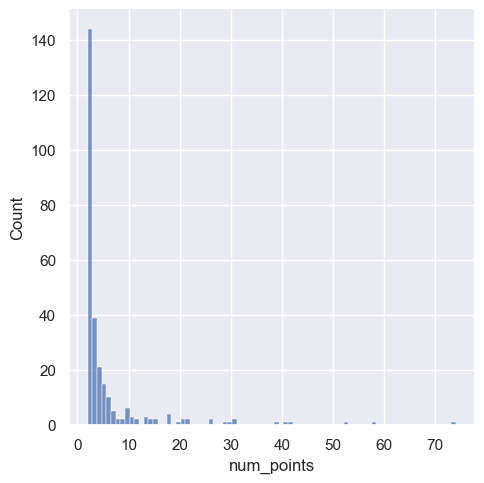

In [3]:
print(f"total number of road vertices: {ub_walkway['num_points'].sum()}")

sns.displot(x="num_points", data=ub_walkway, kind="hist")

In [4]:
points_df = pd.Series(list(chain.from_iterable(
    ub_walkway.apply(lambda line: [p for p in line['geometry'].coords], axis=1)
))).to_frame()

print(f"points_df.shape: {points_df.shape}")
points_df.head()

points_df.shape: (1565, 1)


,0
0,"(-78.78607950162117, 43.00990081100238)"
1,"(-78.7862343806616, 43.009900277753545)"
2,"(-78.78689293143123, 43.00990560784922)"
3,"(-78.78702412978768, 43.00988642045962)"
4,"(-78.78713152770352, 43.00984550270828)"


In [5]:
points_count_df = points_df.value_counts().to_frame().rename(columns={0: "count"}).reset_index().rename(
    columns={0: "coord"})
ub_walkway_vertices = gpd.GeoDataFrame(points_count_df,
                                       geometry=points_count_df["coord"].apply(lambda p: shapely.geometry.Point(p)))
ub_walkway_vertices.drop("coord", axis=1, inplace=True)
print(f"ub_walkway_vertices.shape: {ub_walkway_vertices.shape}")
ub_walkway_vertices.head()

ub_walkway_vertices.shape: (1236, 2)


,count,geometry
0,6,POINT (-78.79251 43.00018)
1,4,POINT (-78.78988 43.00147)
2,4,POINT (-78.79515 42.99933)
3,3,POINT (-78.78672 42.99749)
4,3,POINT (-78.77628 43.00225)


<AxesSubplot:>

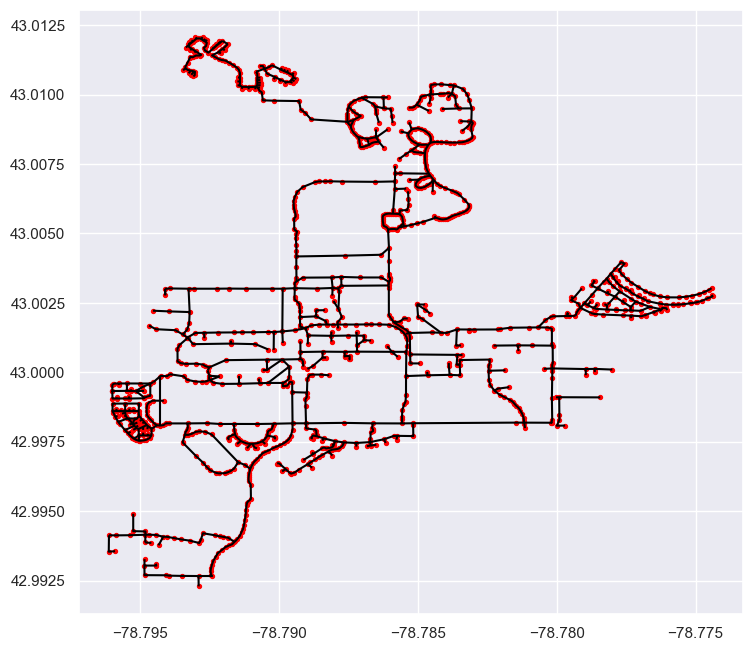

In [6]:
ax = ub_walkway.plot(figsize=(10, 8), color="black")
ub_walkway_vertices.plot(ax=ax, markersize=8, color="red", marker="o")

# Convert from GeoDataFrame to Graph

Reference: [Converting from GeoDataFrame to Graph and back](http://docs.momepy.org/en/stable/user_guide/graph/convert.html)

In [7]:
ub_walkway.head()

,geometry,num_points
unique_id,,
0,"LINESTRING (-78.78608 43.00990, -78.78623 43.0...",53
1,"LINESTRING (-78.78682 43.00841, -78.78675 43.0...",2
2,"LINESTRING (-78.78749 43.00956, -78.78733 43.0...",9
3,"LINESTRING (-78.78732 43.00908, -78.78736 43.0...",4
4,"LINESTRING (-78.78316 43.00903, -78.78307 43.0...",74


In [8]:
ub_walkway_segmented = gpd.GeoDataFrame(geometry=segmented(ub_walkway["geometry"]))
ub_walkway_segmented["length"] = ub_walkway_segmented.length
print(f"ub_walkway_segmented.shape: {ub_walkway_segmented.shape}")
ub_walkway_segmented.head()

ub_walkway_segmented.shape: (1279, 2)


,geometry,length
0,"LINESTRING (-78.78608 43.00990, -78.78623 43.0...",0.000155
1,"LINESTRING (-78.78623 43.00990, -78.78689 43.0...",0.000659
2,"LINESTRING (-78.78689 43.00991, -78.78702 43.0...",0.000133
3,"LINESTRING (-78.78702 43.00989, -78.78713 43.0...",0.000115
4,"LINESTRING (-78.78713 43.00985, -78.78730 43.0...",0.000178


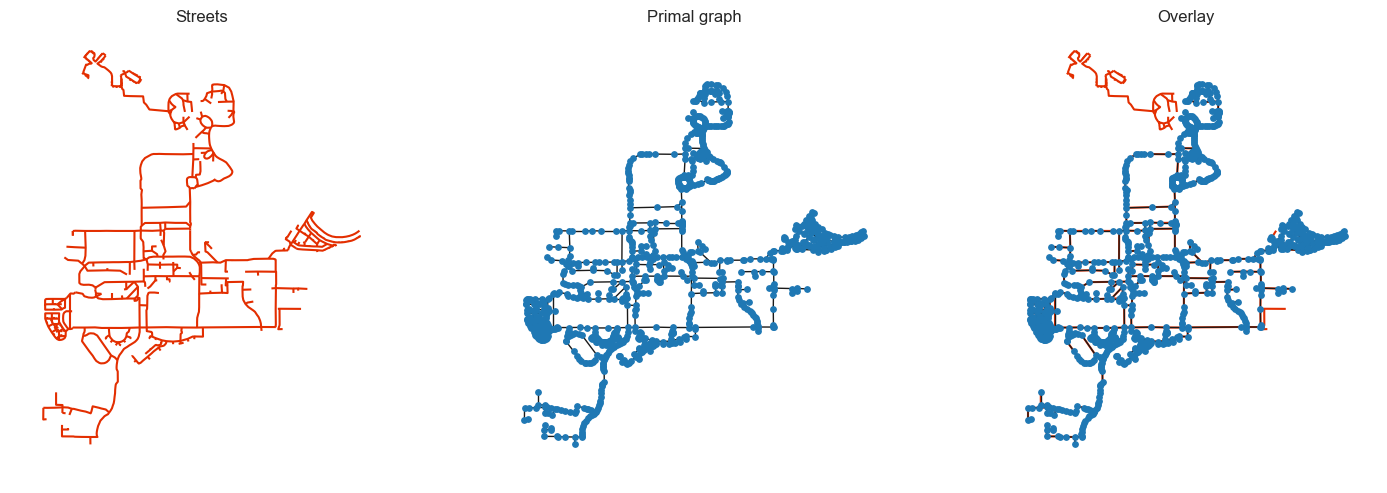

In [9]:
ub_walkway_network = RoadNetwork(lines=ub_walkway["geometry"])

f, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for i, facet in enumerate(ax):
    facet.set_title(("Streets", "Primal graph", "Overlay")[i])
    facet.axis("off")

ub_walkway.plot(color='#e32e00', ax=ax[0])
nx.draw(ub_walkway_network.nx_graph, {n: [n[0], n[1]] for n in list(ub_walkway_network.nx_graph.nodes)}, ax=ax[1], node_size=15)
ub_walkway.plot(color='#e32e00', ax=ax[2], zorder=-1)
nx.draw(ub_walkway_network.nx_graph, {n: [n[0], n[1]] for n in list(ub_walkway_network.nx_graph.nodes)}, ax=ax[2], node_size=15)

<AxesSubplot:>

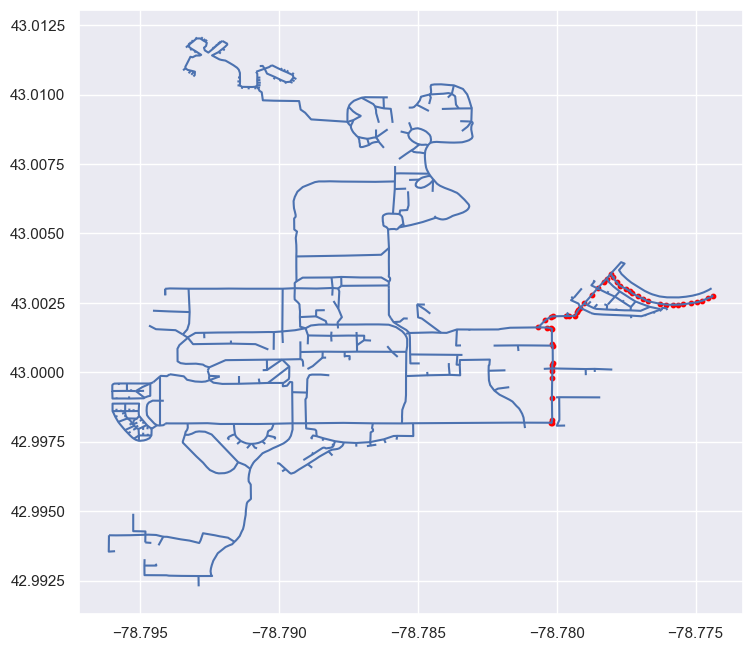

In [10]:
from shapely.geometry import Point

path = ub_walkway_network.get_shortest_path((-78, 43), (-78, 42))
path_gdf = gpd.GeoDataFrame(geometry=[Point(p) for p in path])

ax = ub_walkway.plot(figsize=(10, 8))
path_gdf.plot(marker='o', color='red', markersize=10, ax=ax)

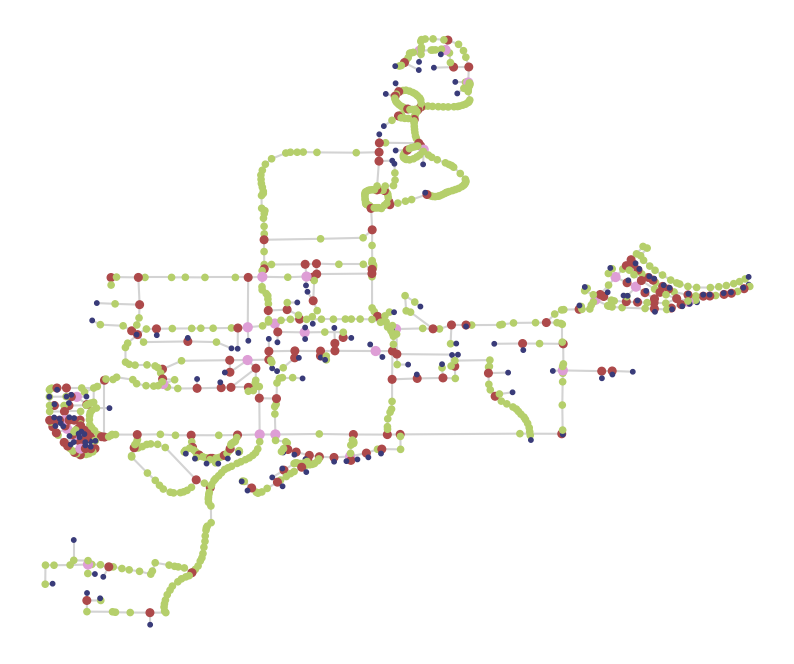

In [11]:
degree = dict(nx.degree(ub_walkway_network.nx_graph))
nx.set_node_attributes(ub_walkway_network.nx_graph, degree, 'degree')

graph = momepy.node_degree(ub_walkway_network.nx_graph, name='degree')

nodes, edges, sw = momepy.nx_to_gdf(graph, points=True, lines=True,
                                    spatial_weights=True)

f, ax = plt.subplots(figsize=(10, 10))
nodes.plot(ax=ax, column='degree', cmap='tab20b', markersize=(nodes['degree'] * 10), zorder=2)
edges.plot(ax=ax, color='lightgrey', zorder=1)
ax.set_axis_off()
plt.show()

In [12]:
print(f"nodes.shape: {nodes.shape}")
nodes.head()

nodes.shape: (1002, 3)


,degree,nodeID,geometry
0,2,0,POINT (-78.78316 43.00903)
1,4,1,POINT (-78.78307 43.00902)
2,2,2,POINT (-78.78304 43.00901)
3,2,3,POINT (-78.78303 43.00899)
4,2,4,POINT (-78.78302 43.00896)


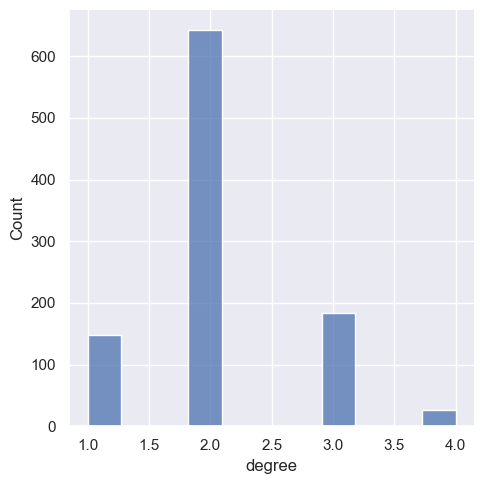

In [13]:
sns.displot(x="degree", data=nodes)

In [14]:
print(f"edges.shape: {edges.shape}")
edges.head()

edges.shape: (1047, 4)


,geometry,length,node_start,node_end
0,"LINESTRING (-78.78316 43.00903, -78.78307 43.0...",0.000086,0,1
1,"LINESTRING (-78.78316 43.00903, -78.78347 43.0...",0.000314,0,412
2,"LINESTRING (-78.78307 43.00902, -78.78304 43.0...",0.000033,1,2
3,"LINESTRING (-78.78307 43.00902, -78.78321 43.0...",0.000223,1,560
4,"LINESTRING (-78.78307 43.00902, -78.78306 43.0...",0.000480,1,862
